In [1]:
import pandas as pd
import numpy as np
import os
os.chdir('../../../../')
print(os.getcwd())
from v2.strategy.indicators.optimal_v2 import Optimal_v2
from v2.model import Trading
from v2.strategy.indicators.param import Param
from v2.strategy.indicators.notebook_utils import fetchIndicators, genDataForAll, generateSpans
from load_config import load_config
from v2.strategy.indicators.momentum import Momentum
import time
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight
from xgboost import XGBClassifier
from sklearn.inspection import permutation_importance

/Users/rosscopeland/Desktop/personal/code/vivaldi/back_testing


In [16]:
#adding in indicators
model = Trading(load_config("config.hjson"))
dataset_list = []

feature_names = []

for list_d, name in model.df_groups:
    inter_df_list = []
    for d in list_d:
        now = time.time()
        cur_dataset = d
        my_inds = fetchIndicators(['macd', 'optimal_v2'])
        genDataForAll(cur_dataset, my_inds)

        feature_names.extend(generateSpans(cur_dataset, 'momentum', 'close', 'period', [5, 10, 20, 30, 40, 50]))
        feature_names.extend(generateSpans(cur_dataset, 'psar', 'close', 'acceleration', [0.01, 0.02, 0.05, 0.1]))
        feature_names.extend(generateSpans(cur_dataset, 'cci', 'close', 'period', [5, 10, 15, 20, 40, 50]))
        feature_names.extend(generateSpans(cur_dataset, 'beta', 'close', 'period', [5, 10, 20, 50, 100, 500]))
        feature_names.extend(generateSpans(cur_dataset, 'rsi', 'close', 'period', [5, 10, 15, 20, 30, 50]))
        feature_names.extend(generateSpans(cur_dataset, 'willr', 'close', 'period', [5, 10, 15, 20, 50, 100]))

        cur_dataset.dropna(inplace=True)
        mm_scalar = MinMaxScaler()
        # cur_dataset[["rsi", "stosc_k", "stosc_d"]] = mm_scalar.fit_transform(cur_dataset[["rsi", "stosc_k", "stosc_d"]])
        inter_df_list.append(cur_dataset)
        print("Time elapsed: {} seconds".format(time.time() - now))

    inter_df_list = pd.concat(inter_df_list)

    # print(inter_df_list[[name for name in feature_names]])

    feature_names.extend(["MACD", "MACD_hist", "MACD_signal"])

    mm_scalar = MinMaxScaler()
    print("begin scaling")
    inter_df_list[feature_names] = mm_scalar.fit_transform(inter_df_list[feature_names])
    print("end scaling")

    dataset_list.append(inter_df_list)
final_dataset = pd.concat(dataset_list)

#first try 172.11971712112427

Time elapsed: 2.797657012939453 seconds
Time elapsed: 1.2556500434875488 seconds
Time elapsed: 3.2141268253326416 seconds
Time elapsed: 2.679995059967041 seconds
Time elapsed: 3.3548500537872314 seconds
Time elapsed: 1.5399377346038818 seconds
Time elapsed: 2.294782876968384 seconds
Time elapsed: 2.1337761878967285 seconds
Time elapsed: 2.017245054244995 seconds
Time elapsed: 1.8184289932250977 seconds
Time elapsed: 1.5840961933135986 seconds
Time elapsed: 3.6631579399108887 seconds
begin scaling
end scaling


In [17]:
def filter_optimal_buy(optimal):
    if optimal > 0.7:
        return 1.0
    return 0.0

def filter_optimal_sell(optimal):
    if optimal < -0.7:
        return 1.0
    return 0.0

# for dataset, name in model.dfs:
#     dataset['optimal'] = dataset.apply(lambda x: filter_optimal(x.optimal), axis=1)
final_dataset['optimal_buy'] = final_dataset.apply(lambda x: filter_optimal_buy(x.Optimal_v2), axis=1)
final_dataset['optimal_sell'] = final_dataset.apply(lambda x: filter_optimal_sell(x.Optimal_v2), axis=1)
final_dataset

,time,high,low,close,open,volume,MACD,MACD_signal,MACD_hist,Optimal_v2,...,RSI_close_period_30,RSI_close_period_50,WILLR_close_period_5,WILLR_close_period_10,WILLR_close_period_15,WILLR_close_period_20,WILLR_close_period_50,WILLR_close_period_100,optimal_buy,optimal_sell
713,1502985359999,4377.54,4377.54,4381.026748,4377.54,0.372734,0.530265,0.566748,0.551758,0.0,...,0.320169,0.334486,0.486732,0.431630,0.265357,0.177001,0.096375,0.084051,0.0,0.0
714,1502985419999,4377.54,4371.52,4379.283374,4371.52,0.315711,0.529887,0.566621,0.551324,0.0,...,0.315702,0.330887,0.486752,0.429011,0.238185,0.144981,0.078830,0.068750,0.0,0.0
715,1502985479999,4377.54,4377.54,4378.411687,4377.54,0.000000,0.529513,0.566492,0.550898,0.0,...,0.313438,0.329078,0.486697,0.427701,0.224598,0.128971,0.070058,0.061100,0.0,0.0
716,1502985539999,4352.34,4352.34,4365.375844,4352.34,0.169983,0.529031,0.566360,0.550308,0.0,...,0.281963,0.303528,0.486839,0.432181,0.266437,0.178275,0.110026,0.097977,0.0,0.0
717,1502985599999,4352.34,4333.42,4358.857922,4333.42,6.399274,0.528554,0.566224,0.549730,0.0,...,0.267928,0.291822,0.487756,0.440279,0.349406,0.276046,0.185138,0.167388,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223224,1606715999999,18524.07,18515.78,18519.207620,18516.15,5.437391,0.592886,0.624342,0.580448,0.0,...,0.408195,0.463166,0.487401,0.429327,0.187185,0.063255,0.055141,0.390364,0.0,0.0
223225,1606719659999,18559.77,18512.90,18523.983810,18520.27,65.068932,0.592652,0.624370,0.580053,0.0,...,0.426505,0.473120,0.486870,0.436562,0.249213,0.110315,0.096895,0.417304,0.0,0.0
223226,1606719719999,18530.08,18523.66,18525.301905,18528.89,15.367476,0.592408,0.624395,0.579645,0.0,...,0.431533,0.475862,0.486943,0.438859,0.304572,0.123302,0.108418,0.424739,0.0,0.0
223227,1606719779999,18530.08,18520.47,18526.950952,18526.62,54.298657,0.592173,0.624418,0.579253,0.0,...,0.437914,0.479323,0.487035,0.441733,0.370183,0.163180,0.122834,0.434040,0.0,0.0


In [18]:
dataset = final_dataset.drop(["Optimal_v2", "volume", "time", "high", "low", "open"], axis=1)
dataset

,close,MACD,MACD_signal,MACD_hist,Momentum_close_period_5,Momentum_close_period_10,Momentum_close_period_20,Momentum_close_period_30,Momentum_close_period_40,Momentum_close_period_50,...,RSI_close_period_30,RSI_close_period_50,WILLR_close_period_5,WILLR_close_period_10,WILLR_close_period_15,WILLR_close_period_20,WILLR_close_period_50,WILLR_close_period_100,optimal_buy,optimal_sell
713,4381.026748,0.530265,0.566748,0.551758,0.452751,0.532353,0.513975,0.529035,0.540974,0.556720,...,0.320169,0.334486,0.486732,0.431630,0.265357,0.177001,0.096375,0.084051,0.0,0.0
714,4379.283374,0.529887,0.566621,0.551324,0.451601,0.531379,0.517749,0.529152,0.540593,0.556298,...,0.315702,0.330887,0.486752,0.429011,0.238185,0.144981,0.078830,0.068750,0.0,0.0
715,4378.411687,0.529513,0.566492,0.550898,0.453587,0.524935,0.519454,0.527571,0.539332,0.556210,...,0.313438,0.329078,0.486697,0.427701,0.224598,0.128971,0.070058,0.061100,0.0,0.0
716,4365.375844,0.529031,0.566360,0.550308,0.456775,0.517147,0.516629,0.525059,0.535703,0.553081,...,0.281963,0.303528,0.486839,0.432181,0.266437,0.178275,0.110026,0.097977,0.0,0.0
717,4358.857922,0.528554,0.566224,0.549730,0.459755,0.513652,0.516006,0.523802,0.533771,0.551516,...,0.267928,0.291822,0.487756,0.440279,0.349406,0.276046,0.185138,0.167388,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223224,18519.207620,0.592886,0.624342,0.580448,0.468930,0.524225,0.505584,0.522810,0.550130,0.571306,...,0.408195,0.463166,0.487401,0.429327,0.187185,0.063255,0.055141,0.390364,0.0,0.0
223225,18523.983810,0.592652,0.624370,0.580053,0.470568,0.525938,0.506510,0.523382,0.552562,0.571210,...,0.426505,0.473120,0.486870,0.436562,0.249213,0.110315,0.096895,0.417304,0.0,0.0
223226,18525.301905,0.592408,0.624395,0.579645,0.472102,0.530706,0.502802,0.525442,0.556656,0.572487,...,0.431533,0.475862,0.486943,0.438859,0.304572,0.123302,0.108418,0.424739,0.0,0.0
223227,18526.950952,0.592173,0.624418,0.579253,0.474552,0.533367,0.503035,0.525072,0.558632,0.574289,...,0.437914,0.479323,0.487035,0.441733,0.370183,0.163180,0.122834,0.434040,0.0,0.0


In [19]:
train, test = train_test_split(dataset, test_size=0.2, shuffle=False)

In [20]:
#random sampling to make a better distribution of optimal and not. Not for time series senstive data (LSTM, GRU)
buy_signals = train[train['optimal_buy'] != 0.0]
sell_signals = train[train['optimal_sell'] != 0.0]

mean_num_singals = int(np.mean([len(buy_signals), len(sell_signals)]))

not_signals = train[(train['optimal_buy'] == 0.0) & (train["optimal_sell"] == 0)]

print(mean_num_singals, len(not_signals))

not_signals_sampled = not_signals.sample(n=min(mean_num_singals * 4, len(not_signals)), random_state=69420, axis=0)

balanced_data_buy = pd.concat([not_signals_sampled, buy_signals])
balanced_data_sell = pd.concat([not_signals_sampled, sell_signals])
balanced_data_all = pd.concat([not_signals_sampled, buy_signals, sell_signals])

68258 1234568


In [21]:
#creating 
balanced_data_X = balanced_data_all.drop(["optimal_buy", "optimal_sell", "close"], axis=1)

balanced_data_sell_y = balanced_data_all[["optimal_sell"]]
balanced_data_buy_y = balanced_data_all[["optimal_buy"]]

test_X = test.drop(["optimal_buy", "optimal_sell", "close"], axis=1)

test_sell_y = test[["optimal_sell"]]
test_buy_y = test[["optimal_buy"]]

train_X = train.drop(["optimal_buy", "optimal_sell", "close"], axis=1)

train_sell_y = train[["optimal_sell"]]
train_buy_y = train[["optimal_buy"]]

sell_weights = class_weight.compute_class_weight('balanced', np.unique(balanced_data_sell_y.to_numpy()[:,0]), balanced_data_sell_y.to_numpy()[:,0])
sell_weights = {i : sell_weights[i] for i in range(2)}

buy_weights = class_weight.compute_class_weight('balanced', np.unique(balanced_data_buy_y.to_numpy()[:,0]), balanced_data_buy_y.to_numpy()[:,0])
buy_weights = {i : buy_weights[i] for i in range(2)}

print(sell_weights)
print(buy_weights)

{0: 0.6000120134550697, 1: 2.9996996996996996}
{0: 0.5999891590022766, 1: 3.000271054328078}


In [22]:
#making more simple classifer as a baseline
clf_sell = RandomForestClassifier(random_state=69420, n_jobs=-1, class_weight=sell_weights, min_samples_leaf=1, n_estimators=25)#, n_estimators=10)

clf_sell.fit(balanced_data_X.values, balanced_data_sell_y.values)

print("Score of classifer is {} ".format(clf_sell.score(test_X.values, test_sell_y.values)))

feature_importances = permutation_importance(clf_sell, balanced_data_X.values, balanced_data_sell_y.values, n_repeats=10, random_state=69420)

for i in range(len(feature_importances.importances_mean)):
    print('i: {}, Feature: {}, Score: {}'.format(i, balanced_data_X.columns[i], feature_importances.importances_mean[i]))

Score of classifer is 0.9116584785221663 
i: 0, Feature: MACD, Score: 0.005226236665209749
i: 1, Feature: MACD_signal, Score: 0.005412050816874137
i: 2, Feature: MACD_hist, Score: 0.0045855318899569505
i: 3, Feature: Momentum_close_period_5, Score: 0.05645942243785231
i: 4, Feature: Momentum_close_period_10, Score: 0.02657484208238816
i: 5, Feature: Momentum_close_period_20, Score: 0.012752076064158336
i: 6, Feature: Momentum_close_period_30, Score: 0.010682726609025982
i: 7, Feature: Momentum_close_period_40, Score: 0.010496179944280126
i: 8, Feature: Momentum_close_period_50, Score: 0.007245775230802632
i: 9, Feature: PSAR_close_acceleration_0.01, Score: 0.015538067483988439
i: 10, Feature: PSAR_close_acceleration_0.02, Score: 0.013865740119008919
i: 11, Feature: PSAR_close_acceleration_0.05, Score: 0.05457979387081885
i: 12, Feature: PSAR_close_acceleration_0.1, Score: 0.06940390527140829
i: 13, Feature: CCI_close_period_5, Score: 0.10469736222039358
i: 14, Feature: CCI_close_period

In [23]:
#making more simple classifer as a baseline
clf_buy = RandomForestClassifier(random_state=69420, n_jobs=-1, class_weight=buy_weights, min_samples_leaf=1, n_estimators=25)#, n_estimators=10)

clf_buy.fit(balanced_data_X.values, balanced_data_buy_y.values)

print("Score of classifer is {} ".format(clf_buy.score(test_X.values, test_buy_y.values)))

feature_importances = permutation_importance(clf_buy, balanced_data_X.values, balanced_data_buy_y.values, n_repeats=10, random_state=69420)

for i in range(len(feature_importances.importances_mean)):
    print('i: {}, Feature: {}, Score: {}'.format(i, balanced_data_X.columns[i], feature_importances.importances_mean[i]))

Score of classifer is 0.9026524920355221 
i: 0, Feature: MACD, Score: 0.0034655193884004175
i: 1, Feature: MACD_signal, Score: 0.0038337292973490535
i: 2, Feature: MACD_hist, Score: 0.003698458548305583
i: 3, Feature: Momentum_close_period_5, Score: 0.07137460963157034
i: 4, Feature: Momentum_close_period_10, Score: 0.05205579796312528
i: 5, Feature: Momentum_close_period_20, Score: 0.02060705800771092
i: 6, Feature: Momentum_close_period_30, Score: 0.013208431713909697
i: 7, Feature: Momentum_close_period_40, Score: 0.007908943740553643
i: 8, Feature: Momentum_close_period_50, Score: 0.0051481019365204215
i: 9, Feature: PSAR_close_acceleration_0.01, Score: 0.017603998544740696
i: 10, Feature: PSAR_close_acceleration_0.02, Score: 0.031147432907906038
i: 11, Feature: PSAR_close_acceleration_0.05, Score: 0.0670391088734193
i: 12, Feature: PSAR_close_acceleration_0.1, Score: 0.07852173976740266
i: 13, Feature: CCI_close_period_5, Score: 0.09508679059160198
i: 14, Feature: CCI_close_period

In [30]:
def insert_buys(row):
    if row.predict_buy > 0.6:
        return row.close
    # if row.predict == 2.0 :# and heat_val > 0.6:
    #     return row.close
    else:
        return None

def insert_sells(row):
    if row.predict_sell > 0.5:
        return row.close
    # if row.predict == 0.0:
    #     return row.close
    else:
        return None

In [31]:
test_graph = test.drop(["optimal_sell", "optimal_buy"], axis=1)
test_graph.dropna(inplace=True)
test_graph

,close,MACD,MACD_signal,MACD_hist,Momentum_close_period_5,Momentum_close_period_10,Momentum_close_period_20,Momentum_close_period_30,Momentum_close_period_40,Momentum_close_period_50,...,RSI_close_period_15,RSI_close_period_20,RSI_close_period_30,RSI_close_period_50,WILLR_close_period_5,WILLR_close_period_10,WILLR_close_period_15,WILLR_close_period_20,WILLR_close_period_50,WILLR_close_period_100
79937,6836.991837,0.530454,0.534928,0.589770,0.467855,0.532148,0.520490,0.541913,0.553779,0.573769,...,0.365554,0.396704,0.434623,0.473722,0.487392,0.452929,0.472129,0.356036,0.241804,0.531558
79938,6831.190918,0.530344,0.535007,0.589508,0.465623,0.531263,0.517874,0.539249,0.552478,0.571486,...,0.315432,0.354514,0.403483,0.454262,0.487016,0.441147,0.364102,0.240743,0.192398,0.473751
79939,6828.190459,0.530235,0.535084,0.589246,0.462101,0.530397,0.516259,0.538320,0.552511,0.570039,...,0.293143,0.335057,0.388523,0.444579,0.486831,0.434046,0.290431,0.169560,0.140104,0.443851
79940,6830.550230,0.530159,0.535160,0.589040,0.464126,0.531819,0.515917,0.538766,0.553811,0.570831,...,0.332988,0.363870,0.406303,0.453875,0.487218,0.439631,0.348371,0.225543,0.186666,0.467367
79941,6830.915115,0.530077,0.535234,0.588824,0.464813,0.531433,0.515160,0.539904,0.552895,0.572137,...,0.339162,0.368328,0.409055,0.455316,0.487354,0.440494,0.357330,0.234200,0.193866,0.471003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223224,18519.207620,0.592886,0.624342,0.580448,0.468930,0.524225,0.505584,0.522810,0.550130,0.571306,...,0.286385,0.342434,0.408195,0.463166,0.487401,0.429327,0.187185,0.063255,0.055141,0.390364
223225,18523.983810,0.592652,0.624370,0.580053,0.470568,0.525938,0.506510,0.523382,0.552562,0.571210,...,0.334126,0.373986,0.426505,0.473120,0.486870,0.436562,0.249213,0.110315,0.096895,0.417304
223226,18525.301905,0.592408,0.624395,0.579645,0.472102,0.530706,0.502802,0.525442,0.556656,0.572487,...,0.347049,0.382600,0.431533,0.475862,0.486943,0.438859,0.304572,0.123302,0.108418,0.424739
223227,18526.950952,0.592173,0.624418,0.579253,0.474552,0.533367,0.503035,0.525072,0.558632,0.574289,...,0.363610,0.393594,0.437914,0.479323,0.487035,0.441733,0.370183,0.163180,0.122834,0.434040


In [32]:
# test_graph["predict_sell"], test_graph["predict_none"], test_graph["predict_buy"] = clf.predict_proba(balanced_data_X.values)
# test_graph[["predict_sell", "predict_none"]] = clf_sell.predict_proba(test_graph.drop("close", axis=1).values)
# test["predict_sell"] = clf.predict_proba(test.drop("predict_buy", axis=1).values)
# test_graph["buy"] = test_graph.apply(lambda x: insert_buys(x), axis=1)
test_graph["predict_sell"] = clf_sell.predict_proba(test_X.values)[:,1]
test_graph["predict_buy"] = clf_buy.predict_proba(test_X.values)[:,1]

test_graph["sell"] = test_graph.apply(lambda x: insert_sells(x), axis=1)
test_graph["buy"] = test_graph.apply(lambda x: insert_buys(x), axis=1)


In [33]:
# first_amnt = test_graph.head(600)
first_amnt = test_graph[3000:4000]
# first_amnt = first_amnt[100000:]

In [34]:
first_amnt.reset_index(inplace=True, drop=True)

<Figure size 432x288 with 0 Axes>

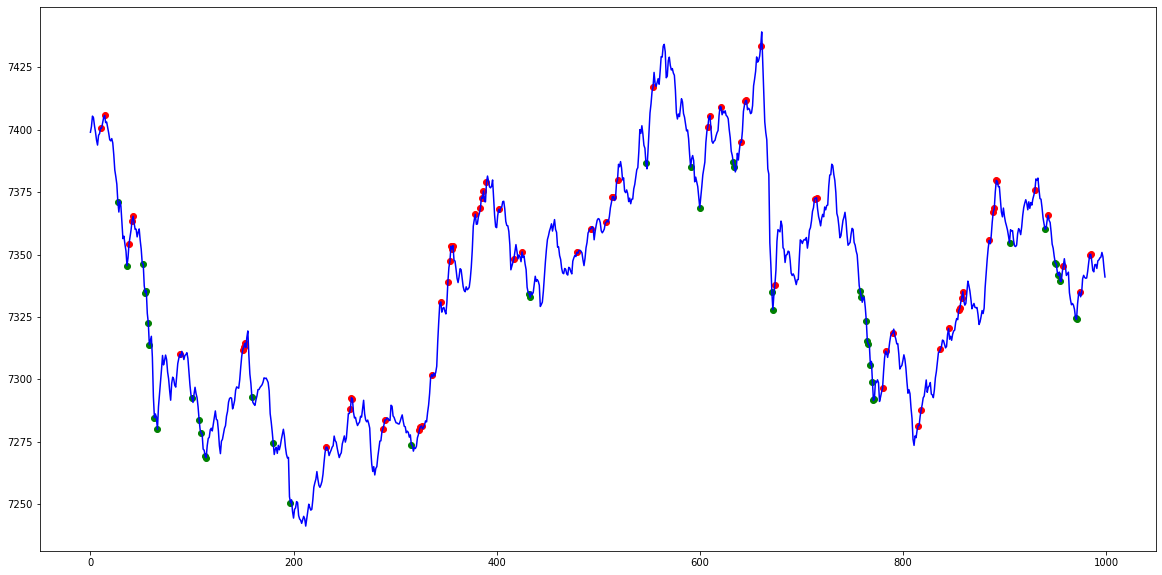

In [35]:
import matplotlib.pyplot as plt
plt.clf()
plt.figure(figsize=(20,10))

# axes = plt.gca()
# axes.set_ylim([0,10000])


plt.scatter(x=first_amnt.index, y=first_amnt['buy'], color='green')
plt.scatter(x=first_amnt.index, y=first_amnt['sell'], color='red')

plt.plot(first_amnt.index, first_amnt['close'], color='blue')
plt.show()